In [ ]:
!pip install timm
!pip install lightning
!pip install astropy
import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import sys
sys.path.append('/content/')

from dataloader_fits import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/Dataset/aia_synoptic_copy_1.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 10
batch_size = 2
learning_rate = 0.001
dropout = 0.5
lstm_layers = 2

k_folds = 5

In [ ]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

In [ ]:
dataset = SunImageDataset(csv_file="/content/dataset_collab_full_6days.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size]
k_fold_2_indices = indices[fold_size:2*fold_size]
k_fold_3_indices = indices[2*fold_size:3*fold_size]
k_fold_4_indices = indices[3*fold_size:4*fold_size]
k_fold_5_indices = indices[4*fold_size:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list
kp_dates = pd.read_csv("/content/matched_kp_dates_collab_full_6days.csv")
kp_dates_list = kp_dates["date"].tolist()

1097
1097
1097
1097
1099


In [ ]:
# Get active indices
dataset_csv_file = pd.read_csv("/content/dataset_collab_full_6days.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)

active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))

for dataloader in active_dataloaders:
    print(len(dataloader))

298
256
380
441
305


In [ ]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()

        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)

        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )


        self.lstm = nn.LSTM(hidden_size, hidden_size * 2, lstm_layers, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_size*2, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            # nn.LeakyReLU()

        )

    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """

        batch_size = images.shape[0]

        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, 10, -1)

        # hidden_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # cell_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # image_features, _ = self.lstm(image_features, (hidden_states, cell_states))
        image_features, _ = self.lstm(image_features)

        image_features = image_features[:, -1, :]
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1

    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):

    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss

def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1





In [ ]:
def train_model(fabric):
  print(fabric.device)
  total_avg_test_loss = 0
  total_rmse = 0
  total_mse = 0
  total_mae = 0
  total_r2 = 0
  total_r = 0
  total_tts = 0
  total_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0

  active_total_avg_test_loss = 0
  active_total_rmse = 0
  active_total_mse = 0
  active_total_mae = 0
  active_total_r2 = 0
  active_total_r = 0


  for i in range(k_folds):
      print(f'FOLD {i + 1}')
      print('--------------------------------')
      test_indices = dataloaders[i]
      active_test_indices = active_dataloaders[i]
      train_indices = []
      for j in range(k_folds):
          if j != i:
              train_indices += dataloaders[j]

      trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=20, prefetch_factor=6, pin_memory=True, worker_init_fn=lambda _: np.random.seed(42))
      testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      trainloader = fabric.setup_dataloaders(trainloader)
      testloader = fabric.setup_dataloaders(testloader)
      active_testloader = fabric.setup_dataloaders(active_testloader)


      # Reinitialize model
      model = GmiSwinTransformer(hidden_size=hidden_size)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      model, optimizer = fabric.setup(model, optimizer)
      model.train()

      # Training the model
      n_total_steps = len(trainloader)
      avg_train_loss_over_epochs = []
      avg_val_loss_over_epochs = []

      for epoch in range(num_epochs):
          train_losses = []
          val_losses = []

          # Training loop
          model.train()
          for i, (images, labels) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
              # Move images and labels to device
              images = images.float()
              labels = labels.float()

              # Forward pass with autograd
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

              # Backward pass and optimization
              optimizer.zero_grad()
              fabric.backward(loss)
              optimizer.step()
              # Store the loss
              train_losses.append(loss.item())

          # Store the average training loss for this epoch
          avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
          print("Average Training Loss: ", sum(train_losses) / len(train_losses))

          # Validation loop
          model.eval()
          with torch.no_grad():
              for images, labels in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                  images = images.float()
                  # images = images.permute(1, 0, 2, 3, 4)
                  labels = labels.float()
                  outputs = model(images).squeeze(1)
                  loss = criterion(outputs, labels)
                  # print("Validation Loss: ", loss.item())
                  val_losses.append(loss.item())

          # Store the average validation loss for this epoch
          avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
          print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

      # Plot loss over epochs
      plt.figure()
      plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
      plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
      plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
      plt.xlabel('Epoch')
      plt.ylabel('Average Loss')
      plt.legend()
      plt.title('Training and Validation Loss Over Epochs')
      plt.show()

      test_losses = []
      all_labels = []
      all_outputs = []

      model.eval()

      print('--------------------------------')
      print('Test for Full set')
      print('--------------------------------')

  # Test for Full set
      with torch.no_grad():
          for images, labels in tqdm(testloader, desc="Testing Progress"):
              images = images.float()
              # images = images.permute(1, 0, 2, 3, 4)
              labels = labels.float()
              # print("Label: ", labels)
              outputs = model(images).squeeze(1)
              # print("Output: ", outputs)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      total_avg_test_loss += avg_test_loss
      total_rmse += rmse
      total_mse += mse
      total_mae += mae
      total_r2 += r2
      total_r += r
      total_tts += tts
      total_accuracy += accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1


      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')

      test_dates = list(kp_dates_list[i] for i in test_indices)
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
      plt.plot([0, len(test_dates)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')
      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Format x-axis with dates
      test_dates_sliced = test_dates[0:len(all_labels):20]
      plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Date', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)

      print('--------------------------------')
      print('Test for Active Periods')
      print('--------------------------------')

      test_losses = []
      all_labels = []
      all_outputs = []

  # Test for active periods
      with torch.no_grad():
          for images, labels in tqdm(active_testloader, desc="Testing Progress"):
              images = images.float()
              labels = labels.float()
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)



      # Accumulate metrics for averaging across folds
      active_total_avg_test_loss += avg_test_loss
      active_total_rmse += rmse
      active_total_mse += mse
      active_total_mae += mae
      active_total_r2 += r2
      active_total_r += r




      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with a window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')

      plt.plot([0, len(all_labels)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')

      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Sample Index', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)


  print('--------------------------------')
  print('Metrics for Full Set')
  print('--------------------------------')

  # Average metrics across all folds
  total_avg_test_loss /= k_folds
  total_rmse /= k_folds
  total_mse /= k_folds
  total_mae /= k_folds
  total_r2 /= k_folds
  total_r /= k_folds
  total_tts /= k_folds
  total_accuracy /= k_folds
  total_precision /= k_folds
  total_recall /= k_folds
  total_f1 /= k_folds

  print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
  print(f'Average RMSE across all folds: {total_rmse:.4f}')
  print(f'Average MSE across all folds: {total_mse:.4f}')
  print(f'Average MAE across all folds: {total_mae:.4f}')
  print(f'Average R² across all folds: {total_r2:.4f}')
  print(f'Average R across all folds: {total_r:.4f}')
  print(f'Average True Skill Score across all folds: {total_tts:.4f}')
  print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
  print(f'Average Precision across all folds: {total_precision:.4f}')
  print(f'Average Recall across all folds: {total_recall:.4f}')
  print(f'Average F1 Score across all folds: {total_f1:.4f}')

  print('--------------------------------')
  print('Metrics for Active Periods')
  print('--------------------------------')
  # Average metrics across all folds
  active_total_avg_test_loss /= k_folds
  active_total_rmse /= k_folds
  active_total_mse /= k_folds
  active_total_mae /= k_folds
  active_total_r2 /= k_folds
  active_total_r /= k_folds

  print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
  print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
  print(f'Average active MSE across all folds: {active_total_mse:.4f}')
  print(f'Average active MAE across all folds: {active_total_mae:.4f}')
  print(f'Average active R² across all folds: {active_total_r2:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')




INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0
FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.4742143136192594


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.76382256888586


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.878891587819361


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7901092658306257


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5211047797254207


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9092625078133634


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.1156914712910504


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.047131961934864


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.8159419593204488


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.117354299864751


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6649019690698446


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2267757871114853


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5547158082222796


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0964395280719463


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.483061686610052


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.404118156809642


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4141239945667273


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.149776702031505


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.36215632456721875


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1830979192248616


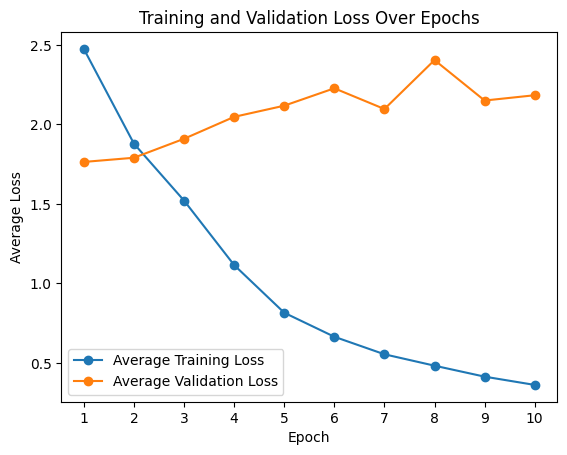

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.1831
RMSE: 1.4775
MSE: 2.1848
MAE: 1.1430
R²: -0.2383
R: 0.0706
True Skill Score: 0.0940
Accuracy: 0.6682
Precision: 0.2054
Recall: 0.0772
F1 Score: 0.1122


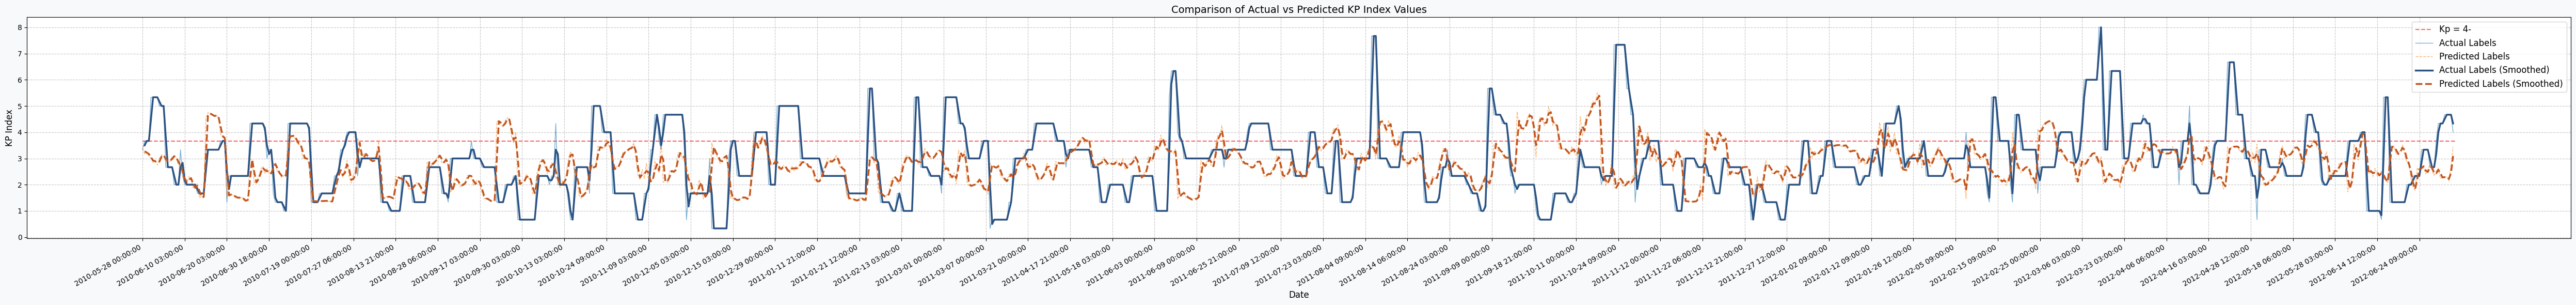

[np.float32(3.375), np.float32(3.171875), np.float32(3.265625), np.float32(3.078125), np.float32(3.015625), np.float32(2.828125), np.float32(2.953125), np.float32(2.75), np.float32(3.0), np.float32(3.140625), np.float32(3.109375), np.float32(2.859375), np.float32(2.9375), np.float32(2.875), np.float32(3.078125), np.float32(3.09375), np.float32(3.0), np.float32(2.75), np.float32(2.71875), np.float32(2.3125), np.float32(2.15625), np.float32(2.0625), np.float32(2.3125), np.float32(2.1875), np.float32(1.8828125), np.float32(1.875), np.float32(2.03125), np.float32(1.4921875), np.float32(1.5859375), np.float32(1.484375), np.float32(4.5), np.float32(4.75), np.float32(4.6875), np.float32(4.65625), np.float32(4.59375), np.float32(4.65625), np.float32(4.53125), np.float32(3.921875), np.float32(3.796875), np.float32(3.765625), np.float32(1.5234375), np.float32(1.65625), np.float32(1.59375), np.float32(1.625), np.float32(1.484375), np.float32(1.53125), np.float32(1.4765625), np.float32(1.5390625),

Testing Progress:   0%|          | 0/149 [00:00<?, ?it/s]

Average test loss: 4.3034
RMSE: 2.0745
MSE: 4.3034
MAE: 1.7463
R²: -3.9467
R: -0.0861


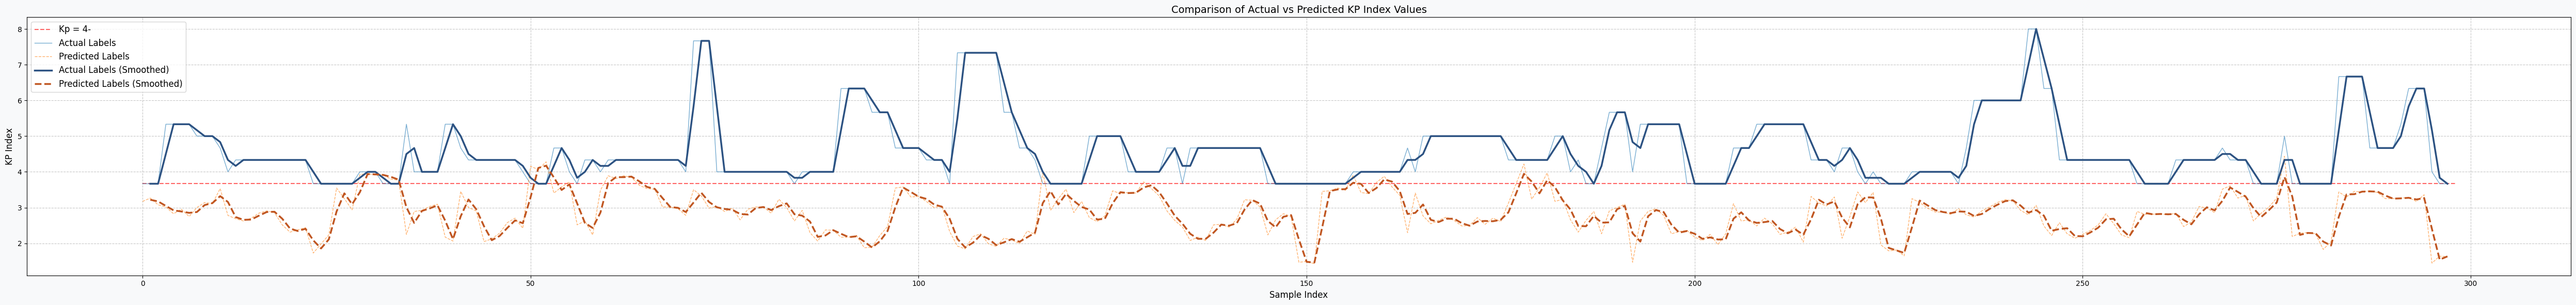

[np.float32(3.171875), np.float32(3.265625), np.float32(3.078125), np.float32(3.015625), np.float32(2.828125), np.float32(2.953125), np.float32(2.75), np.float32(3.0), np.float32(3.140625), np.float32(3.109375), np.float32(3.53125), np.float32(2.78125), np.float32(2.6875), np.float32(2.625), np.float32(2.703125), np.float32(2.84375), np.float32(2.90625), np.float32(2.859375), np.float32(2.515625), np.float32(2.3125), np.float32(2.375), np.float32(2.4375), np.float32(1.7265625), np.float32(1.984375), np.float32(2.234375), np.float32(3.546875), np.float32(3.25), np.float32(2.9375), np.float32(3.921875), np.float32(3.953125), np.float32(3.90625), np.float32(3.921875), np.float32(3.796875), np.float32(3.765625), np.float32(2.25), np.float32(2.890625), np.float32(2.921875), np.float32(3.03125), np.float32(3.09375), np.float32(2.171875), np.float32(2.0625), np.float32(3.453125), np.float32(3.0), np.float32(2.90625), np.float32(2.046875), np.float32(2.125), np.float32(2.28125), np.float32(2.5

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.3715150490437384


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0540816720137425


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.7412255719746013


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9747235136314976


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.4516289344408013


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.051227392203629


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.0852736926713697


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.3637552803411115


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.8818111068300759


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.6043276566426177


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6860118391623949


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.391238507322432


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5643452595924939


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2845806716336954


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4557578376234502


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.468332357974473


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.40486342165581296


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.3515542051169636


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.35618779273439305


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.5366182925184186


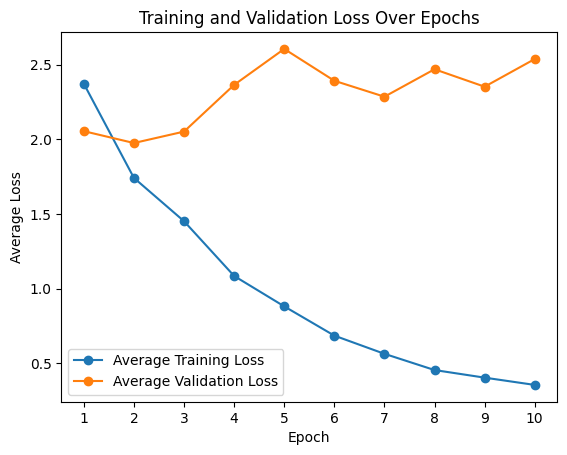

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.5366
RMSE: 1.5927
MSE: 2.5382
MAE: 1.3004
R²: -0.2799
R: 0.0292
True Skill Score: 0.1806
Accuracy: 0.7101
Precision: 0.3198
Recall: 0.2148
F1 Score: 0.2570


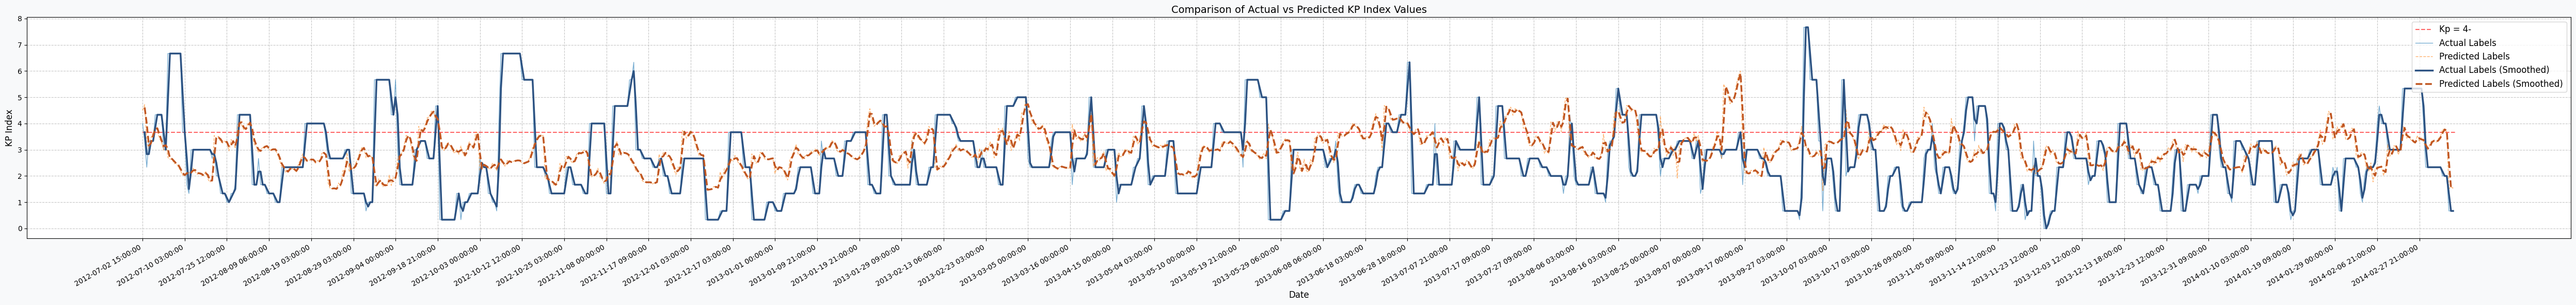

[np.float32(4.5), np.float32(4.71875), np.float32(3.265625), np.float32(3.046875), np.float32(3.453125), np.float32(3.640625), np.float32(3.90625), np.float32(3.734375), np.float32(3.4375), np.float32(3.28125), np.float32(2.984375), np.float32(3.359375), np.float32(2.703125), np.float32(2.640625), np.float32(2.65625), np.float32(2.46875), np.float32(2.484375), np.float32(2.34375), np.float32(2.203125), np.float32(2.03125), np.float32(2.03125), np.float32(2.15625), np.float32(2.125), np.float32(2.125), np.float32(2.296875), np.float32(2.15625), np.float32(2.0625), np.float32(2.140625), np.float32(2.015625), np.float32(2.015625), np.float32(2.1875), np.float32(1.8828125), np.float32(1.765625), np.float32(1.8828125), np.float32(3.546875), np.float32(3.421875), np.float32(3.515625), np.float32(3.296875), np.float32(3.265625), np.float32(3.328125), np.float32(3.265625), np.float32(2.953125), np.float32(3.390625), np.float32(3.265625), np.float32(3.046875), np.float32(3.875), np.float32(4.15

Testing Progress:   0%|          | 0/128 [00:00<?, ?it/s]

Average test loss: 4.1015
RMSE: 2.0252
MSE: 4.1015
MAE: 1.6669
R²: -3.8554
R: -0.1415


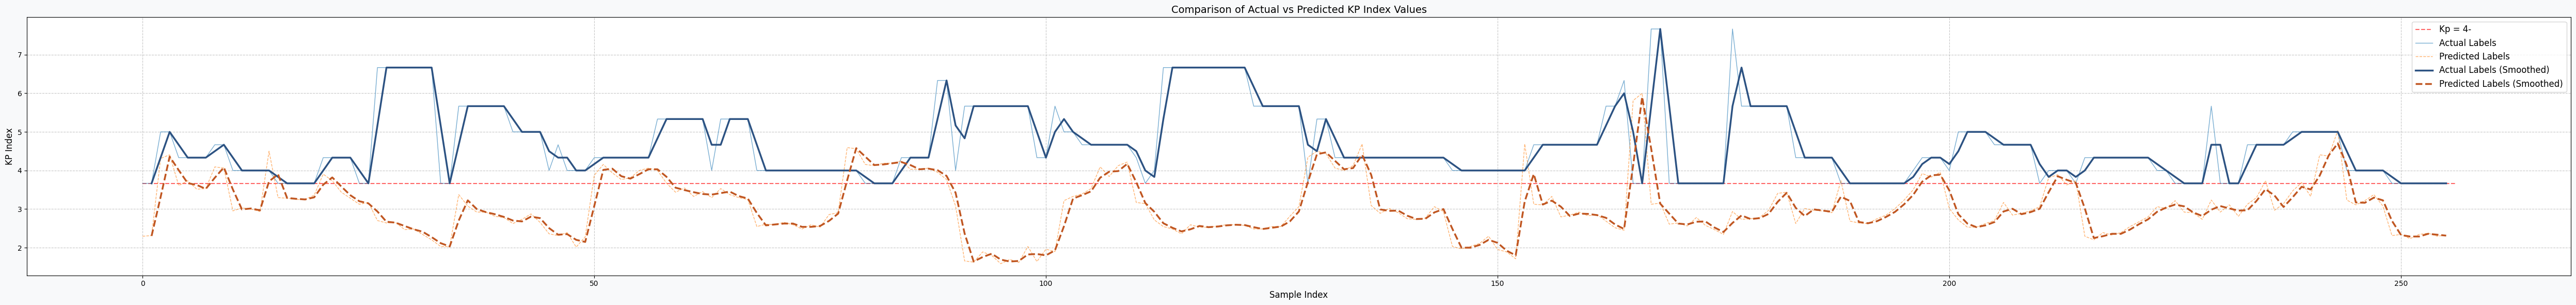

[np.float32(2.296875), np.float32(2.3125), np.float32(4.3125), np.float32(4.40625), np.float32(3.609375), np.float32(3.734375), np.float32(3.515625), np.float32(3.53125), np.float32(4.09375), np.float32(4.0625), np.float32(2.953125), np.float32(3.03125), np.float32(3.0), np.float32(2.9375), np.float32(4.5), np.float32(3.296875), np.float32(3.28125), np.float32(3.25), np.float32(3.25), np.float32(3.359375), np.float32(3.90625), np.float32(3.734375), np.float32(3.4375), np.float32(3.28125), np.float32(3.125), np.float32(3.171875), np.float32(2.703125), np.float32(2.640625), np.float32(2.65625), np.float32(2.46875), np.float32(2.484375), np.float32(2.34375), np.float32(2.203125), np.float32(2.03125), np.float32(2.03125), np.float32(3.375), np.float32(3.078125), np.float32(2.921875), np.float32(2.921875), np.float32(2.8125), np.float32(2.78125), np.float32(2.625), np.float32(2.734375), np.float32(2.875), np.float32(2.65625), np.float32(2.359375), np.float32(2.3125), np.float32(2.390625), n

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.310958118150186


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.027315184626667


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.7976847578495623


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2241351419704896


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.5148870632124585


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.4145601334106277


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.1400757612931842


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.146104729384174


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.8663957017074113


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.3866760341058493


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.699084395209212


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1508019955480946


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5539152656565686


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2768780590821303


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.48035183694302264


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2249130308136125


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3957023606733897


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9859825975315912


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3459997845295067


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2807581209364933


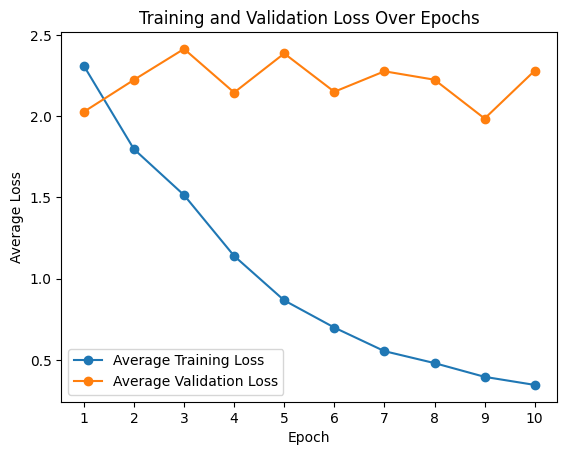

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 2.2808
RMSE: 1.5102
MSE: 2.2828
MAE: 1.1651
R²: -0.1322
R: 0.2872
True Skill Score: 0.4944
Accuracy: 0.6709
Precision: 0.5725
Recall: 0.1974
F1 Score: 0.2935


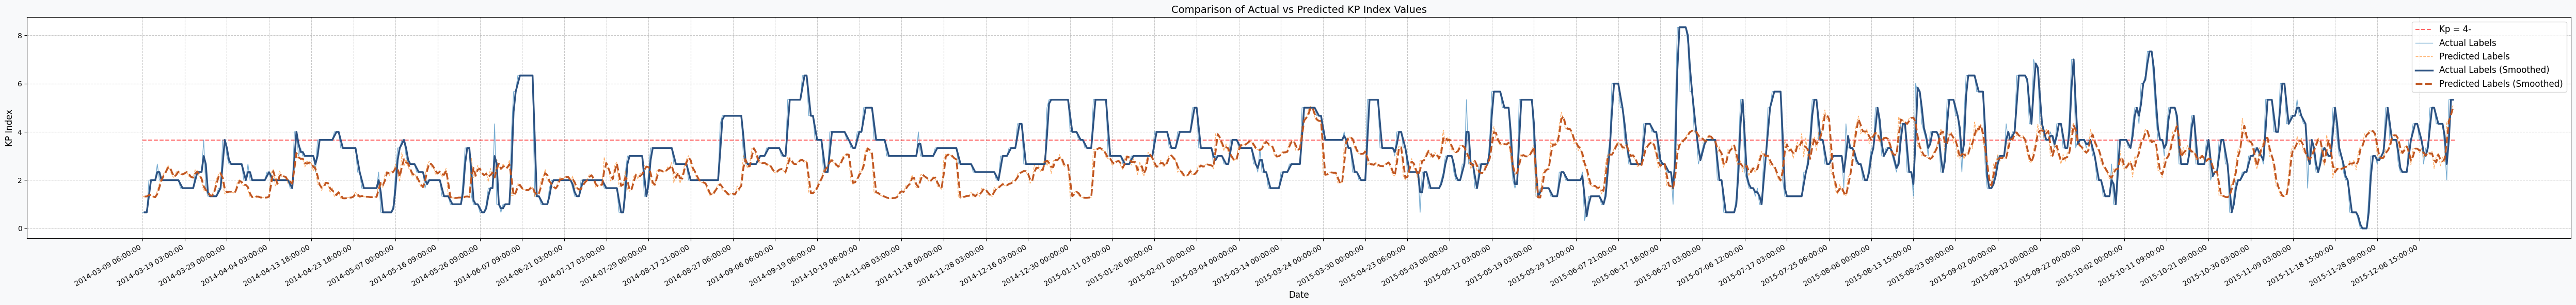

[np.float32(1.3359375), np.float32(1.3046875), np.float32(1.34375), np.float32(1.421875), np.float32(1.359375), np.float32(1.2890625), np.float32(1.296875), np.float32(1.5546875), np.float32(1.8671875), np.float32(2.109375), np.float32(2.265625), np.float32(2.390625), np.float32(2.625), np.float32(2.4375), np.float32(2.1875), np.float32(2.09375), np.float32(2.34375), np.float32(2.359375), np.float32(2.234375), np.float32(2.234375), np.float32(2.328125), np.float32(2.34375), np.float32(2.15625), np.float32(2.109375), np.float32(2.09375), np.float32(2.453125), np.float32(2.265625), np.float32(2.171875), np.float32(1.9453125), np.float32(1.546875), np.float32(1.6328125), np.float32(1.4375), np.float32(1.3046875), np.float32(1.3984375), np.float32(1.6015625), np.float32(2.03125), np.float32(2.21875), np.float32(2.34375), np.float32(1.8671875), np.float32(1.4296875), np.float32(1.5546875), np.float32(1.4921875), np.float32(1.546875), np.float32(1.4609375), np.float32(1.5703125), np.float32(

Testing Progress:   0%|          | 0/190 [00:00<?, ?it/s]

Average test loss: 4.5065
RMSE: 2.1228
MSE: 4.5065
MAE: 1.8147
R²: -3.5491
R: 0.2606


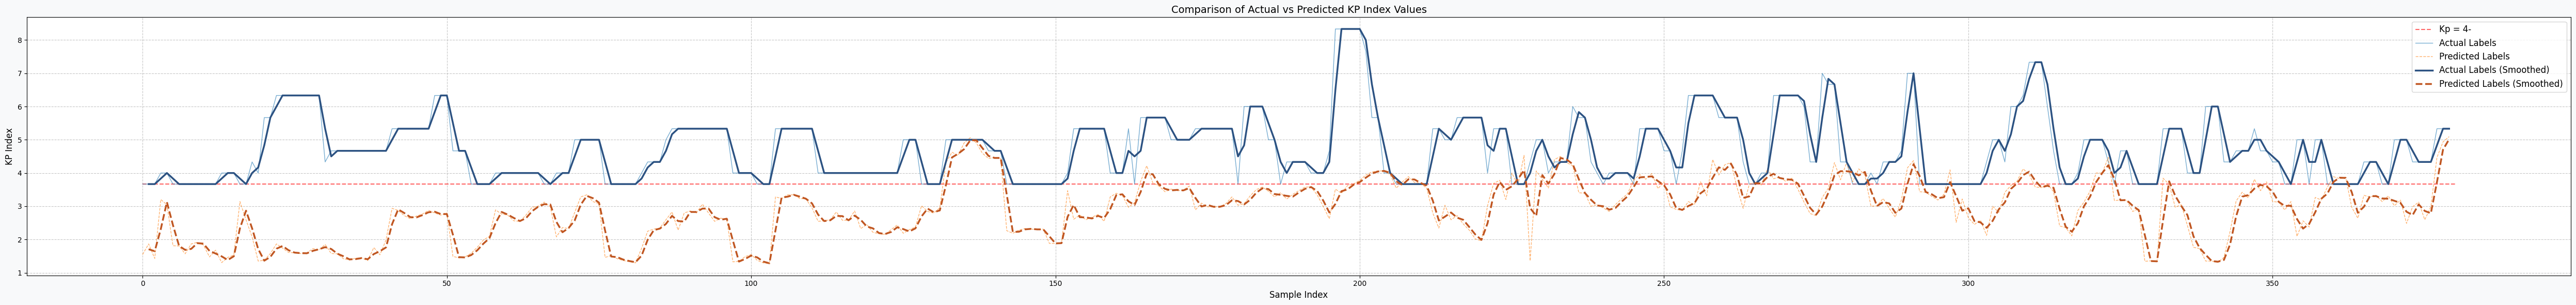

[np.float32(1.546875), np.float32(1.8671875), np.float32(1.4296875), np.float32(3.203125), np.float32(3.046875), np.float32(1.8125), np.float32(1.8046875), np.float32(1.5703125), np.float32(1.8671875), np.float32(1.9140625), np.float32(1.8359375), np.float32(1.4765625), np.float32(1.6796875), np.float32(1.3046875), np.float32(1.4609375), np.float32(1.53125), np.float32(3.140625), np.float32(2.59375), np.float32(2.078125), np.float32(1.3515625), np.float32(1.375), np.float32(1.578125), np.float32(1.8671875), np.float32(1.7421875), np.float32(1.609375), np.float32(1.6015625), np.float32(1.578125), np.float32(1.59375), np.float32(1.7265625), np.float32(1.6875), np.float32(1.8515625), np.float32(1.578125), np.float32(1.5703125), np.float32(1.421875), np.float32(1.3828125), np.float32(1.4375), np.float32(1.4453125), np.float32(1.3671875), np.float32(1.7578125), np.float32(1.5390625), np.float32(1.984375), np.float32(2.9375), np.float32(2.875), np.float32(2.71875), np.float32(2.625), np.floa

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.4238089228637625


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9640908578608163


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.886600823004641


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8854152667731772


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.6148798351527052


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.056677748364857


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.1856580714072638


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.935068486878103


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.8417571394317679


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1505071857125833


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6623602984450303


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8593864488764877


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5246849189377454


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9340934352401244


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.43993731136344943


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.087161147056863


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3792991294110561


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1438033965981154


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.34795519823080434


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9226451031493663


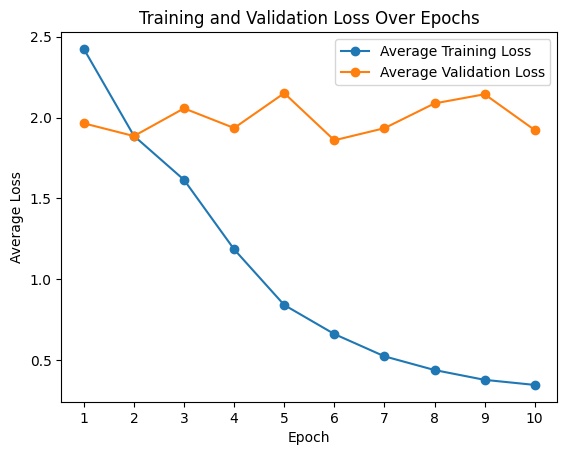

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.9226
RMSE: 1.3866
MSE: 1.9236
MAE: 1.1103
R²: -0.0976
R: 0.2215
True Skill Score: 0.4765
Accuracy: 0.6436
Precision: 0.6106
Recall: 0.3129
F1 Score: 0.4138


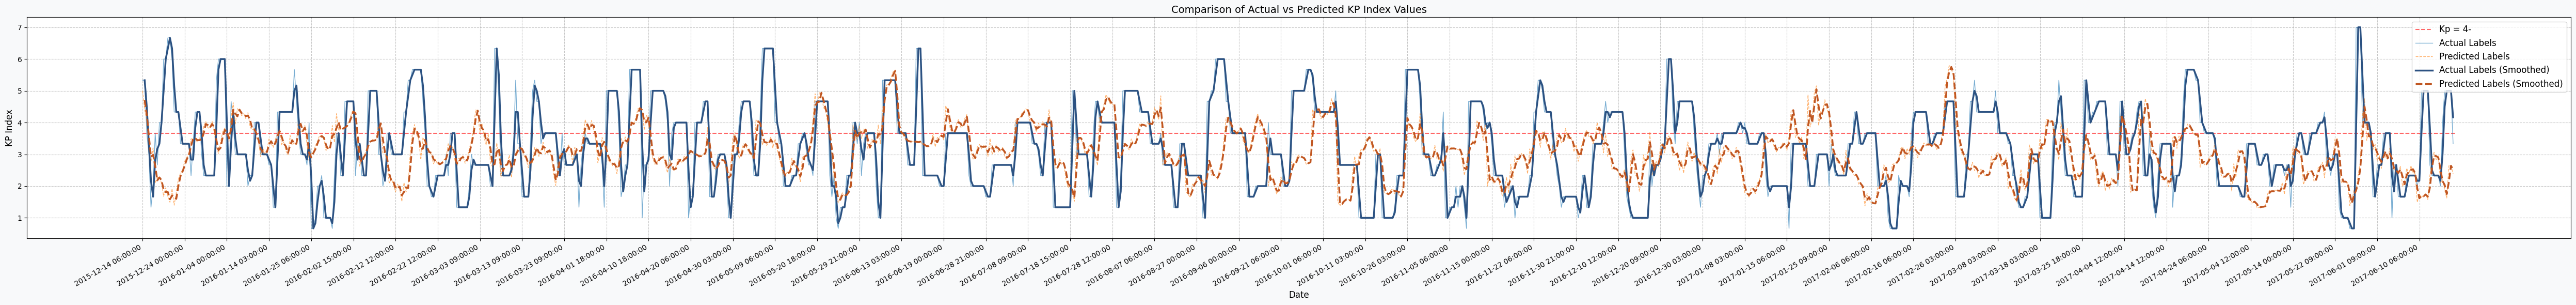

[np.float32(5.0), np.float32(4.40625), np.float32(4.09375), np.float32(3.078125), np.float32(2.765625), np.float32(3.203125), np.float32(2.09375), np.float32(2.265625), np.float32(2.28125), np.float32(2.09375), np.float32(1.6796875), np.float32(1.9453125), np.float32(1.6796875), np.float32(1.4921875), np.float32(1.9140625), np.float32(1.3984375), np.float32(1.796875), np.float32(2.21875), np.float32(2.40625), np.float32(2.515625), np.float32(2.78125), np.float32(2.90625), np.float32(3.046875), np.float32(3.484375), np.float32(3.5), np.float32(3.515625), np.float32(3.375), np.float32(3.515625), np.float32(3.4375), np.float32(3.875), np.float32(4.03125), np.float32(3.8125), np.float32(3.875), np.float32(4.03125), np.float32(3.6875), np.float32(3.234375), np.float32(3.03125), np.float32(3.375), np.float32(3.703125), np.float32(3.828125), np.float32(3.59375), np.float32(3.40625), np.float32(4.1875), np.float32(4.625), np.float32(3.953125), np.float32(4.4375), np.float32(4.375), np.float32(

Testing Progress:   0%|          | 0/221 [00:00<?, ?it/s]

Average test loss: 2.7816
RMSE: 1.6678
MSE: 2.7878
MAE: 1.3518
R²: -3.7634
R: 0.0243


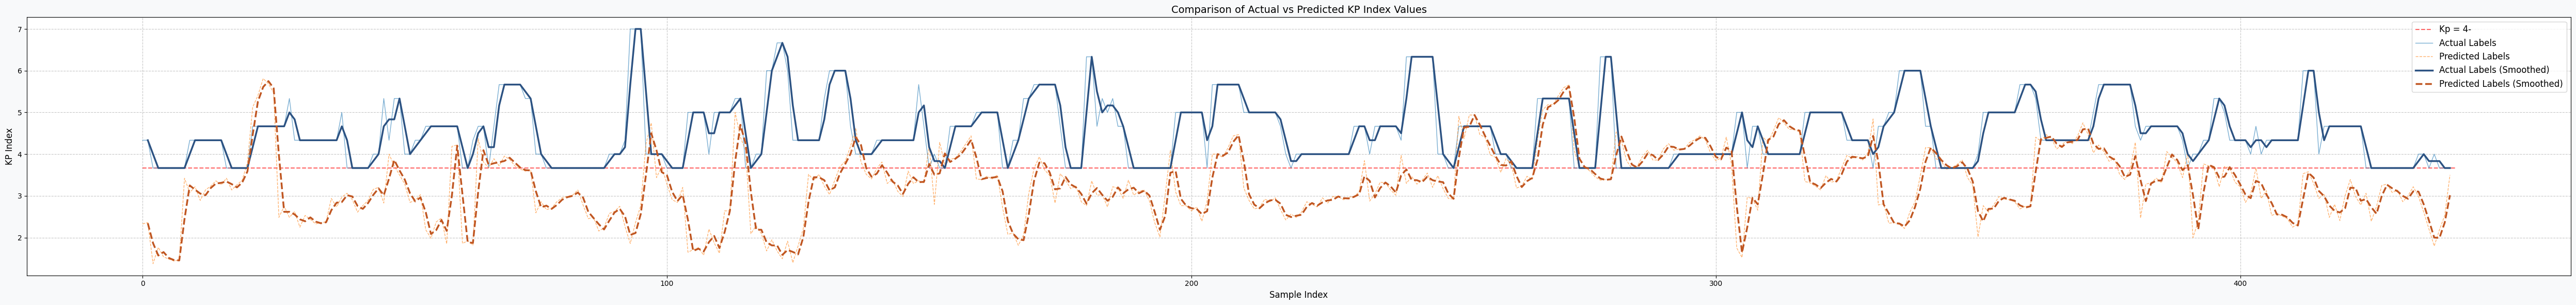

[np.float32(2.328125), np.float32(2.359375), np.float32(1.375), np.float32(1.765625), np.float32(1.5390625), np.float32(1.484375), np.float32(1.4375), np.float32(1.46875), np.float32(3.421875), np.float32(3.078125), np.float32(3.21875), np.float32(2.890625), np.float32(3.140625), np.float32(3.234375), np.float32(3.359375), np.float32(3.265625), np.float32(3.421875), np.float32(3.140625), np.float32(3.265625), np.float32(3.375), np.float32(3.796875), np.float32(5.125), np.float32(5.40625), np.float32(5.8125), np.float32(5.6875), np.float32(5.46875), np.float32(2.484375), np.float32(2.75), np.float32(2.484375), np.float32(2.625), np.float32(2.25), np.float32(2.53125), np.float32(2.4375), np.float32(2.328125), np.float32(2.359375), np.float32(2.375), np.float32(2.9375), np.float32(2.734375), np.float32(2.96875), np.float32(3.0625), np.float32(2.90625), np.float32(2.609375), np.float32(2.765625), np.float32(2.890625), np.float32(3.15625), np.float32(3.203125), np.float32(2.828125), np.floa

Training Progress: Epoch: 1:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  2.432993875454802


Validation Progress: Epoch: 1:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.0511674758667438


Training Progress: Epoch: 2:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.9214617579876117


Validation Progress: Epoch: 2:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.5663920759210703


Training Progress: Epoch: 3:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.6508698838526235


Validation Progress: Epoch: 3:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.266984868301608


Training Progress: Epoch: 4:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.2328545892654363


Validation Progress: Epoch: 4:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.8968283106716857


Training Progress: Epoch: 5:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.9167631207586991


Validation Progress: Epoch: 5:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.261638060299341


Training Progress: Epoch: 6:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.7099767775213421


Validation Progress: Epoch: 6:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.9877869162872561


Training Progress: Epoch: 7:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.5981521841851791


Validation Progress: Epoch: 7:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.0951669549180028


Training Progress: Epoch: 8:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.48885707673070183


Validation Progress: Epoch: 8:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.1155719249678606


Training Progress: Epoch: 9:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.4132062900189887


Validation Progress: Epoch: 9:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.9766811364254153


Training Progress: Epoch: 10:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.3573820248236065


Validation Progress: Epoch: 10:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.0137282104775394


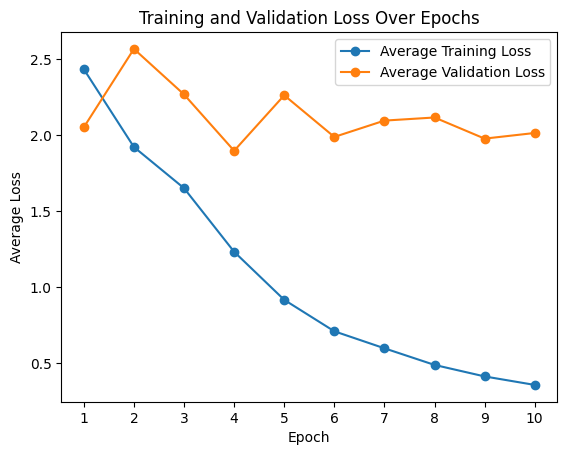

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/550 [00:00<?, ?it/s]

Average test loss: 2.0137
RMSE: 1.4191
MSE: 2.0104
MAE: 1.1909
R²: -0.1867
R: 0.1201
True Skill Score: 0.2367
Accuracy: 0.6824
Precision: 0.3778
Recall: 0.2230
F1 Score: 0.2804


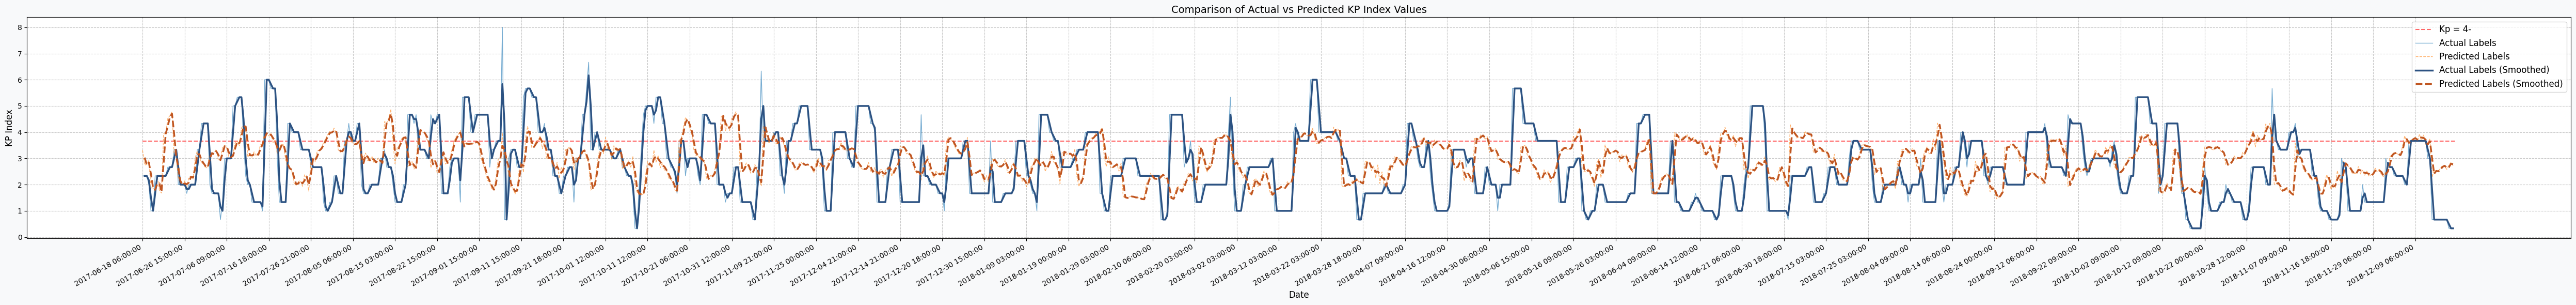

[np.float32(3.3125), np.float32(2.75), np.float32(2.765625), np.float32(2.921875), np.float32(1.875), np.float32(1.875), np.float32(1.734375), np.float32(2.328125), np.float32(1.7734375), np.float32(1.6796875), np.float32(3.9375), np.float32(3.9375), np.float32(4.53125), np.float32(4.625), np.float32(4.78125), np.float32(3.09375), np.float32(3.046875), np.float32(2.265625), np.float32(2.015625), np.float32(1.9609375), np.float32(2.140625), np.float32(1.890625), np.float32(2.265625), np.float32(2.328125), np.float32(2.21875), np.float32(3.015625), np.float32(3.28125), np.float32(3.046875), np.float32(2.84375), np.float32(2.78125), np.float32(2.625), np.float32(2.703125), np.float32(3.28125), np.float32(3.125), np.float32(3.203125), np.float32(3.34375), np.float32(2.9375), np.float32(2.9375), np.float32(3.421875), np.float32(3.5), np.float32(3.40625), np.float32(3.0625), np.float32(3.03125), np.float32(3.171875), np.float32(3.59375), np.float32(3.671875), np.float32(3.484375), np.float32

Testing Progress:   0%|          | 0/153 [00:00<?, ?it/s]

Average test loss: 2.6981
RMSE: 1.6426
MSE: 2.7021
MAE: 1.3992
R²: -4.6569
R: 0.0675


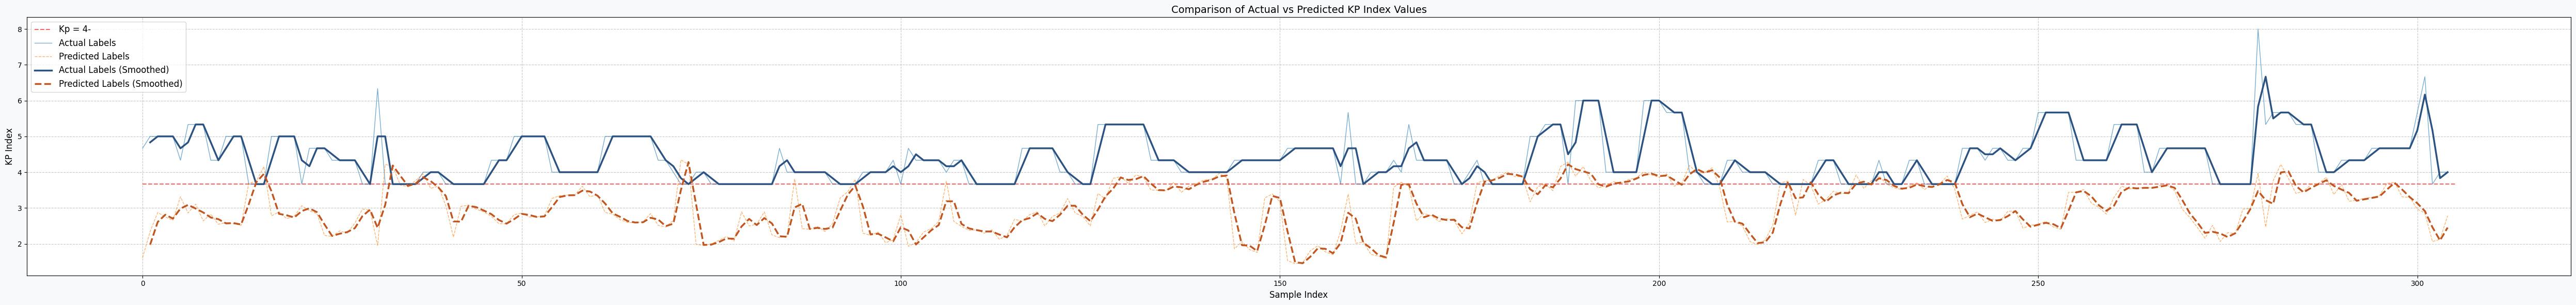

[np.float32(1.609375), np.float32(2.34375), np.float32(2.875), np.float32(2.75), np.float32(2.65625), np.float32(3.3125), np.float32(2.859375), np.float32(3.109375), np.float32(2.640625), np.float32(2.828125), np.float32(2.546875), np.float32(2.59375), np.float32(2.5625), np.float32(2.515625), np.float32(3.6875), np.float32(3.75), np.float32(4.15625), np.float32(2.78125), np.float32(2.890625), np.float32(2.703125), np.float32(2.765625), np.float32(3.0625), np.float32(2.921875), np.float32(2.84375), np.float32(2.234375), np.float32(2.203125), np.float32(2.359375), np.float32(2.296875), np.float32(2.578125), np.float32(2.96875), np.float32(2.9375), np.float32(1.953125), np.float32(4.21875), np.float32(4.15625), np.float32(3.640625), np.float32(3.59375), np.float32(3.765625), np.float32(3.953125), np.float32(3.546875), np.float32(3.609375), np.float32(3.0625), np.float32(2.1875), np.float32(3.046875), np.float32(3.078125), np.float32(2.96875), np.float32(2.890625), np.float32(2.765625), n

In [ ]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch(train_model)

In [ ]:
# prompt: disconnect runtime
import time
time.sleep(5 * 60)
from google.colab import runtime
runtime.unassign()
